In [5]:
%%capture
!pip install -r requirements.txt

# Fine-Tune a DETR model for ppe object detection.

DETR is a Transformer model architecture designed end-to-end Object Detection tasks. First introduced in [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872): by Nicolas Carion et al[^1], the team succesfully combined a convolutional neural network (CNN) with an encoder-decoder model to fully train a model on object detection. They showed how this architecture could be extended to image segmentation as well, another popular computer vision task.

In this notebook, we will fine-tune this Facebook's DETR model on a ppe (personal protective equiptment) data using Domino. We will also leverage Domino's deep integration with MLFlow to track our model performance and log our resulting model to MLFlow.

[^1]: _Nicolas Carion, Francisco Massa, Gabriel Synnaeve, Nicolas Usunier, Alexander Kirillov and Sergey Zagoruyko_

In [1]:
from datasets import load_dataset
from transformers import AutoImageProcessor

DATASET_NAME = "cppe-5"
MODEL_NAME = "facebook/detr-resnet-50"
IMAGE_COL = "image"
OBJECTS_COL = "objects"
LABEL_COL = "category"
# Bounding box coordinates, COCO format
FORMAT = "coco"
BBOX_COL = "bbox"
LOG_MODEL_MLFLOW = True
LOG_DATA_MLFLOW = True

# Load the dataset and the model's image processor
ds = load_dataset(DATASET_NAME)
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Train-test Split

We will split our dataset into train and test. This code handles a few different cases, handling different key names

In [2]:
# Helpers: Determine the split names. Train/test split if doesn't already exist
from PIL.Image import Image as PIL_Image
from datasets import Dataset

# If the dataset dict only has 1 key, we want to split it into train/test
if len(ds.keys()) == 1:
    key = next(iter(ds.keys()))
    ds = ds[key]

# If we have a dataset, we want to create a dict with train/test
if isinstance(ds, Dataset):
    ds = ds.train_test_split(test_size=0.2, stratify_by_column=LABEL_COL)


splits = list(ds.keys())
train_split = "train" if "train" in splits else "training"
eval_split = next(split for split in splits if split != train_split)


## View an image

Let's look at an example image and its bounding boxes

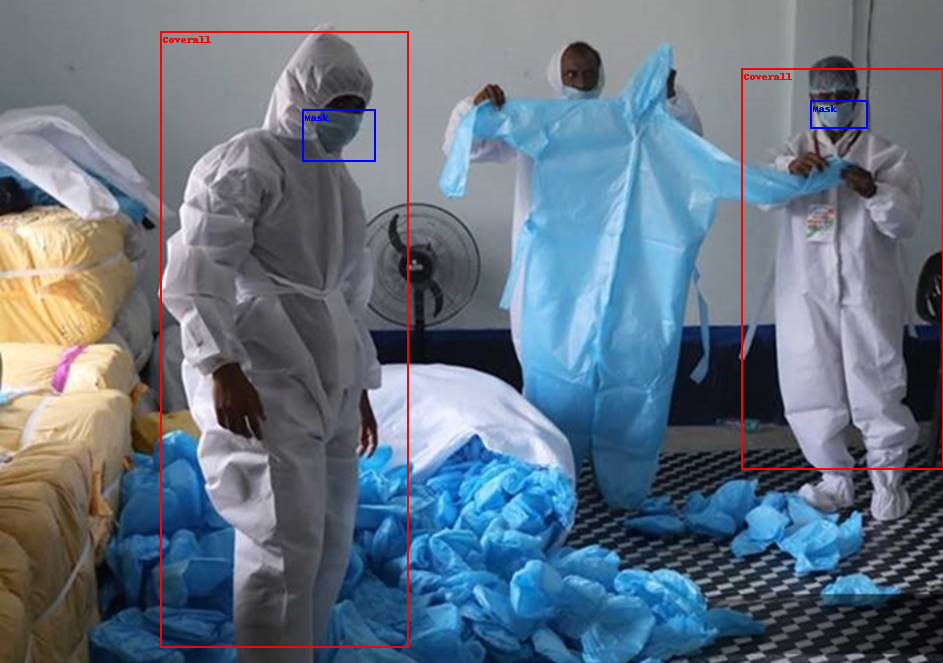

In [3]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

categories = ds[train_split].features[OBJECTS_COL].feature[LABEL_COL]
image = ds[train_split][0][IMAGE_COL]
annotations = ds[train_split][0][OBJECTS_COL]

# COCO Format
boxes_xywh = torch.tensor(annotations[BBOX_COL])
# Convert to xyxy format
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(x) for x in annotations[LABEL_COL]]
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(image),
        boxes_xyxy,
        colors=["blue", "blue", "red", "red"],
        labels=labels,
        width=2,
        font="Arial.tff",
        font_size=15,
    )
)

# We need to apply augmentations to our images in order to train

_We add augmentations to the image to help the training process using `albumentations`_

Here, we resize the images to the required width/height for detr (480, 480). We also apply horizontal flips as well as randomly modifying the brightness contrast. This augmentation helps the model learn more robust representations.

By using albumentations, the bounding boxes are also converted appropraitely.

Learn more at: https://huggingface.co/docs/datasets/object_detection

In [4]:
import albumentations
import numpy as np
import torch


transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format=FORMAT, label_fields=[LABEL_COL]),
)

## View an augmentation

_We see that even though the image is flipped, its bounding boxes are still in the right places with the right labels_

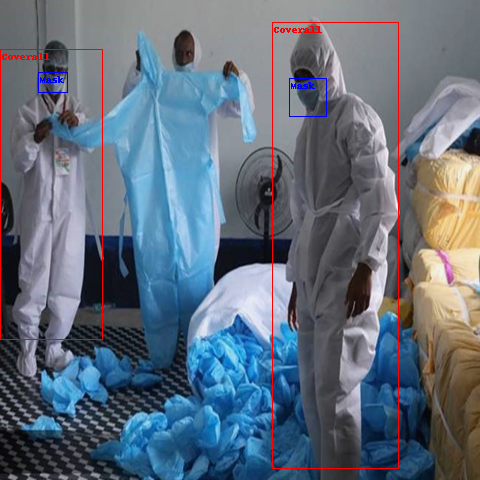

In [7]:
from typing import List, Dict
from PIL import Image

def augment_image(image: Image, annotations: Dict) -> Image:
    # We need to set the image to BGR instead of RGB, because that is what albumentations expects
    flip_image = np.flip(np.array(image), -1)
    out = transform(
        image=flip_image,
        bboxes=annotations[BBOX_COL],
        category=annotations[LABEL_COL],
    )

    # Back to RGB
    image_transformed = torch.tensor(out['image']).flip(-1).permute(2, 0, 1)
    boxes_xywh = torch.stack([torch.tensor(x) for x in out["bboxes"]])
    # Back to COCO format
    boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
    labels = [categories.int2str(x) for x in out[LABEL_COL]]
    return to_pil_image(
        draw_bounding_boxes(
            image_transformed,
            boxes_xyxy,
            colors=["blue", "blue", "red", "red"],
            labels=labels
        )
    )
# Look at one augmented image
augment_image(image, annotations)

## Turn the transformations into a `transforms` function

This will apply the transformation to every row in the dataset.

We use `set_transform` on the dataset to only run these transformations _lazily_, when the row is indexes. We don't want to run them all now, as the memory usage will be too high.

In [8]:
from typing import List, Dict


def formatted_anns(image_id: int, category: Dict, area: List[float], bbox: List[float]) -> List[Dict]:
    """Structure annotations to format: {'image_id': int, 'annotations': List[Dict]}"""
    annotations = []
    for i in range(len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": bbox[i],
        }
        annotations.append(new_ann)

    return annotations


def transform_aug_ann(examples: Dict[str, List]):
    """Transform a batch of examples into annotations"""
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples[IMAGE_COL], examples[OBJECTS_COL]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects[BBOX_COL], category=objects[LABEL_COL])

        area.append(objects["area"])
        images.append(out[IMAGE_COL])
        bboxes.append(out["bboxes"])
        categories.append(out[LABEL_COL])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")


# Use with_transform so these transformations happen on-the-fly rather than all at once
ds.set_transform(transform_aug_ann)

## Post-augmentation validation

After augmentations, it may be possible for certain boxes to no longer be valid. In this simple validation, we ensure that all bounding boxes post-augmentation are still valid. That is, the boundaries of the boxes fall within the size of the image. Invalid boxes (otherwise known as "runaway boxes") have their entire image removed from the training set.

In [9]:
from tqdm.auto import tqdm

for split in ds.keys():
    remove_idx = set()
    for i in tqdm(range(len(ds[split]))):
        try:
            ds[train_split][i]
        except ValueError:
            remove_idx.add(i)

    keep = [i for i in range(len(ds[split])) if i not in remove_idx]
    print(f"{len(remove_idx)} Samples removed from {split}")
    ds[split] = ds[split].select(keep)

  0%|          | 0/1000 [00:00<?, ?it/s]

3 Samples removed from train


  0%|          | 0/29 [00:00<?, ?it/s]

0 Samples removed from test


## Define our data collator

Images can have different sizes (For DETR, min size of 800 and a max size of 1333). So, we need to pad the images in a batch to the largest size within that batch.  

In [10]:
# Create a collate function to batch images together.
# Pad images (which are now pixel_values) to the largest image in a batch,
# and create a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0).
from typing import List, Dict, Any

def collate_fn(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Create a collate function to batch images together.

    Pad images (which are now pixel_values) to the largest image in a batch,
    and create a corresponding pixel_mask to indicate which pixels are real
    (1) and which are padding (0).
    """
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    result = {}
    result["pixel_values"] = encoding["pixel_values"]
    result["pixel_mask"] = encoding["pixel_mask"]
    result["labels"] = labels
    return result


## Training!

Here we begin training. We first set mlflow autologging to True so metrics and parameters are automatically logged.

We then set up our id to label mapping for the foundational model.

Next, we load our ImageClassification pre-trained model that we defined in the first cell, and give it the labels that we have.

Last, we set our training arguments and trainer parameters, and begin training!

In [ ]:
# Training
from transformers import AutoModelForObjectDetection, TrainingArguments, Trainer
import mlflow.transformers


mlflow.transformers.autolog(
    log_input_examples=LOG_DATA_MLFLOW,
    log_model_signatures=LOG_MODEL_MLFLOW,
    log_models=LOG_MODEL_MLFLOW,
    log_datasets=LOG_DATA_MLFLOW
)


labels = ds[train_split].features[OBJECTS_COL].feature[LABEL_COL].names
id2label = dict(enumerate(labels))
label2id = {v: k for k, v in id2label.items()}
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

mlflow_run_name = "cppe_detection_run_1"

training_args = TrainingArguments(
    output_dir=mlflow_run_name,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,  # Warning: If set to False, the memory usage will be very large!
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds[train_split],
    tokenizer=image_processor,
    eval_dataset=ds[eval_split],
)

trainer.train()



## Logging your Data and Models to MLFlow

If you've set either these values to True, we will log the model checkpoints and input dataset to MLFlow directly within Domino.

In [44]:
# Log the dataset and model to mlflow
run_id = mlflow.last_active_run().info.run_id
with mlflow.start_run(run_id=run_id):
    if LOG_MODEL_MLFLOW:
        model_config = {
            "model": trainer.model,
            "image_processor": trainer.tokenizer
        }
        mlflow.transformers.log_model(model_config, artifact_path="model")
    if LOG_DATA_MLFLOW:
        for split in ds.keys():
            data = mlflow.data.from_huggingface(ds[split])
            mlflow.log_input(data, context=split)


<ipython-input-44-11fda04f2ae8>:9: FutureWarning: The 'transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``4.25.1`` -  ``4.33.1``. MLflow Models integrations with transformers may not succeed when used with package versions outside of this range.
  mlflow.transformers.log_model(model_config, artifact_path="model")
/usr/local/lib/python3.10/dist-packages/mlflow/models/model.py:579: FutureWarning: The 'transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``4.25.1`` -  ``4.33.1``. MLflow Models integrations with transformers may not succeed when used with package versions outside of this range.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


2023/10/21 18:34:52 WARNING mlflow.transformers: This model is unable to be used for pyfunc prediction because the model is not a language-based model and requires a complex input type that is currently not supported. The pyfunc flavor will not be added to the Model.
2023/10/21 18:34:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/21 18:34:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.16.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `

## Use our fine-tuned model

Lastly, we can save the model directly to disk, and load it to make predictions.

In our case, we only finetuned this model for 10 epochs, so it likley cannot make any predictions yet. It would need to train for closer to 100 epochs.

Below, we load the same model, fine tuned for 100 epochs on this dataset, and run inference via a `pipeline`

In [26]:
preds_xyxy

tensor([[744,  43, 929, 524],
        [165,  17, 382, 661],
        [308, 105, 370, 151],
        [420,  23, 790, 514]])

Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


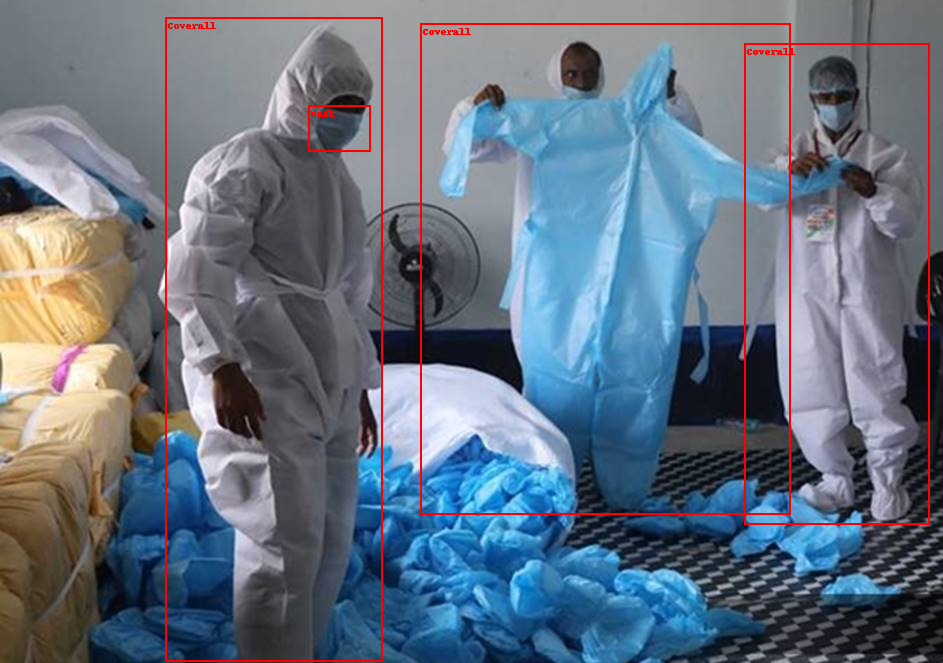

In [32]:
from transformers import pipeline

# Save our model
model_name = f"/mnt/artifacts/{mlflow_run_name}"
trainer.save_model(model_name)
# Load our pipeline
# detector = pipeline("object-detection", model=model_name)
detector = pipeline("object-detection", model="devonho/detr-resnet-50_finetuned_cppe5")

records = load_dataset(DATASET_NAME)[train_split]
image = records[0][IMAGE_COL]

preds = detector(image)
boxes = [p["box"] for p in preds]
labels = [p["label"] for p in preds]
preds_xyxy = torch.tensor([[box["xmin"], box["ymin"], box["xmax"], box["ymax"]] for box in boxes])

to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(image),
        preds_xyxy,
        colors="red",
        labels=labels,
        width=2,
    )
)